In [42]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load data from the merged JSON file
def load_data(merged_file):
    with open(merged_file, 'r') as f:
        data = json.load(f)
    
    rows = []
    for street in data:
        street_name = street['street_name']
        for day_type in ['weekdays', 'weekends']:
            for time_slot in ['09', '12', '15', '18', '21']:
                # Extract traffic entries for this day_type and time_slot
                traffic_entries = street['traffic'][day_type][time_slot]
                for entry in traffic_entries:
                    rows.append({
                        'street': street_name,
                        'day_type': day_type,
                        'time': time_slot,
                        'temperature': entry["temperature"],
                        'speed': entry["speed"],
                        'jamFactor': entry["jamFactor"]
                    })
    
    return pd.DataFrame(rows)

# Preprocess data
def preprocess_data(df):
    # Encode street names
    street_encoder = LabelEncoder()
    df['street_encoded'] = street_encoder.fit_transform(df['street'])
    
    # One-hot encode time
    time_encoder = OneHotEncoder(sparse_output=False)
    time_encoded = time_encoder.fit_transform(df[['time']])
    
    # Encode day_type (weekdays=0, weekends=1)
    df['day_type_encoded'] = df['day_type'].map({'weekdays': 0, 'weekends': 1})
    
    # Scale numerical features (temperature, speed)
    scaler = StandardScaler()
    numerical_features = scaler.fit_transform(df[['temperature', 'speed']])
    
    # Combine all features
    X_street = np.eye(len(street_encoder.classes_))[df['street_encoded']]
    X_day_type = df['day_type_encoded'].values.reshape(-1, 1)
    X_time = time_encoded
    X_numerical = numerical_features
    
    X = np.hstack([X_street, X_day_type, X_time, X_numerical])
    y = df['jamFactor'].values
    
    return X, y, street_encoder, time_encoder, scaler

# Load and preprocess data
merged_file = '../merged-traffic-data/merged_output.json'
df = load_data(merged_file)
X, y, street_encoder, time_encoder, scaler = preprocess_data(df)

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam

# Define the neural network
def build_model(input_shape):
    model = Sequential([
        InputLayer(input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

# Build and train the model
model = build_model(X_train.shape[1])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3511 - mae: 1.4246 - val_loss: 1.2899 - val_mae: 0.8663
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0341 - mae: 0.8205 - val_loss: 0.8585 - val_mae: 0.7113
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7175 - mae: 0.6454 - val_loss: 0.7601 - val_mae: 0.6759
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6355 - mae: 0.6124 - val_loss: 0.6980 - val_mae: 0.6390
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6240 - mae: 0.6049 - val_loss: 0.6587 - val_mae: 0.6074
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5683 - mae: 0.5702 - val_loss: 0.6236 - val_mae: 0.5950
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4973 - mae: 0.5374 - val_loss: 0.5915 - val_mae: 0.5786
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5082 - mae: 0.5306 - val_loss: 0.5690 - val_mae: 0.5582
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4481 - mae: 0.5007 - va

In [26]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MSE: {test_loss:.2f}")

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4314 - mae: 1.5633 - val_loss: 1.3143 - val_mae: 0.9090
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9639 - mae: 0.7919 - val_loss: 0.8712 - val_mae: 0.7357
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8577 - mae: 0.7582 - val_loss: 0.6679 - val_mae: 0.6553
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8333 - mae: 0.7447 - val_loss: 0.5802 - val_mae: 0.6101
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6918 - mae: 0.6677 - val_loss: 0.5612 - val_mae: 0.5954
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6559 - mae: 0.6607 - val_loss: 0.5418 - val_mae: 0.5931
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7425 - mae: 0.6955 - val_loss: 0.5115 - val_mae: 0.5710
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6372 - mae: 0.6392 - val_loss: 0.4794 - val_mae: 0.5570
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.566

In [46]:
import joblib

# Save the model and preprocessing tools
model.save('jam_factor_predictor.keras')
joblib.dump(street_encoder, 'street_encoder.joblib')
joblib.dump(time_encoder, 'time_encoder.joblib')
joblib.dump(scaler, 'scaler.joblib')
print("Model and preprocessing tools saved!")

Model and preprocessing tools saved!


In [48]:
from tensorflow.keras.models import load_model

# Load the model and preprocessing tools
model = load_model('jam_factor_predictor.keras')
street_encoder = joblib.load('street_encoder.joblib')
time_encoder = joblib.load('time_encoder.joblib')
scaler = joblib.load('scaler.joblib')

# Function to make predictions
def predict_jam_factor(day_type, time, street, temperature, speed):
    # Encode street
    street_encoded = street_encoder.transform([street])
    street_onehot = np.eye(len(street_encoder.classes_))[street_encoded]
    
    # Encode day_type
    day_type_encoded = 1 if day_type == 'weekends' else 0
    
    # Encode time
    time_encoded = time_encoder.transform([[time]])
    
    # Scale numerical features
    temp_speed_scaled = scaler.transform([[temperature, speed]])
    
    # Combine features
    X = np.hstack([street_onehot, [[day_type_encoded]], time_encoded, temp_speed_scaled])
    
    # Predict jamFactor
    return model.predict(X, verbose=0)[0][0]

# Example prediction
jam_factor = predict_jam_factor(
    day_type='weekends',
    time='09',
    street='Feldkirchenstraße',
    temperature=5.0,
    speed=10.0
)
print(f"Predicted Jam Factor: {jam_factor:.2f}")

Predicted Jam Factor: 1.68


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [50]:
# Predict on the test set
y_pred = model.predict(X_test, verbose=0).flatten()

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.4307
Mean Squared Error (MSE): 0.4017
Root Mean Squared Error (RMSE): 0.6338


In [ ]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual Jam Factor')
plt.ylabel('Predicted Jam Factor')
plt.title('Actual vs Predicted Jam Factor')
plt.show()

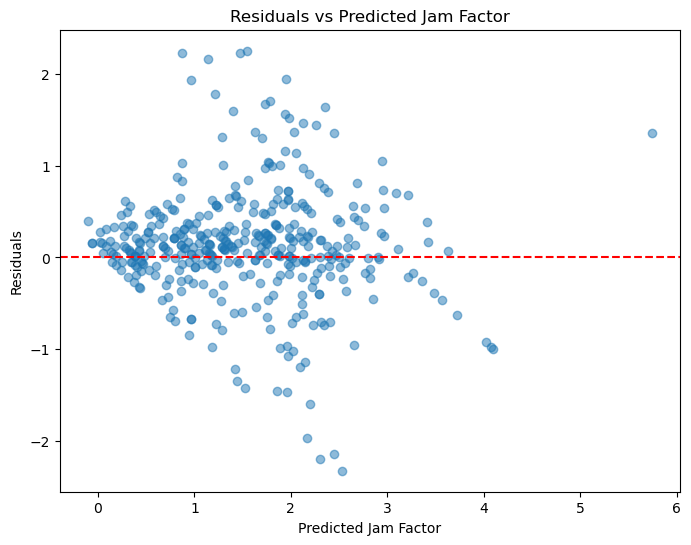

In [56]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at 0
plt.xlabel('Predicted Jam Factor')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Jam Factor')
plt.show()